# Parte B - consultas con SQL
 - En este notebook se recuperan los datos de S3, se crea una base de datos en Athena y se realizan consultas SQL para responder a las preguntas planteadas en el ejercicio. 
 - Cómo las preguntas sólo se refieren a la categoría 'catagolo=basicos'. sólo se cargan los datos de esa partición. 

In [ ]:
# Import required libraries
import os
import boto3
import awswrangler as wr
import pandas as pd
import numpy as np
import yaml
import awswrangler as wr
import matplotlib.pyplot as plt
import seaborn as sns
from pyathena import connect


# Create AWS session - this needs to be available for all chunks
session = boto3.Session(profile_name='arquitectura',
                        region_name='us-east-1')

In [5]:
# Crear la base de datos en Glue/Athena
wr.catalog.create_database(
    name="profeco",
    description="Base de datos para análisis de datos de Profeco",
    boto3_session=session
)


AlreadyExists: Database profeco already exists and <exist_ok> is set to False.

# Creación de una tabla en Athena

In [ ]:
# Ruta del bucket donde están los datos particionados
#Como todas las preguntas son referentes a la categoría básicos, sólo bajamos esa partición.

s3_path = "s3://itam-analytics-marta/profeco/parquet/catalogo=basicos"

# Crear la tabla particionada
#columnas que no son particiones
columns_types = {
    "producto": "string",
    "marca": "string",
    "tipo": "string",
    "precio": "float" ,
    "fecha": "date",
    "estado": "string",
    "ciudad": "string"
}

wr.catalog.create_parquet_table(
    database="profeco",
    table="datos_basicos",
    path=s3_path,
    columns_types=columns_types,
    partitions_types={
        "anio": "int"
    },
    description="Datos de Profeco con particiones por catálogo y año",
    compression="snappy",
    mode="overwrite",
    catalog_versioning=True,
    boto3_session=session
)

wr.s3.store_parquet_metadata(
    path=s3_path,
    database="profeco",
    table="datos_basicos",
    dataset=True,
    mode="update",
    boto3_session=session
)

({'producto': 'string',
  'marca': 'string',
  'tipo': 'string',
  'precio': 'float',
  'fecha': 'date',
  'estado': 'string',
  'ciudad': 'string'},
 {'anio': 'string'},
 {'s3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2018/': ['2018'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2019/': ['2019'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2020/': ['2020'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2021/': ['2021'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2022/': ['2022'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2023/': ['2023'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2024/': ['2024']})

## Queries Soliticadas

- ¿De qué años se tienen datos? 

In [ ]:
#Query: para BASICOS, saber de qué año hay datos:
# Definir la consulta SQL
query = """
SELECT DISTINCT anio
FROM profeco.datos_basicos
ORDER BY anio;
"""

# Ejecutar la consulta y obtener el resultado en un DataFrame
df_resultado = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)
#Mostrar el resultado
df_resultado

   anio
0  2018
1  2019
2  2020
3  2021
4  2022
5  2023
6  2024


- ¿Existen registros de fecha vacíos? 

In [34]:
#Del catalogo BASICOS, contar registro d de fecha vacíos
query="""
SELECT COUNT(*) AS registros_vacios
FROM profeco.datos_basicos
WHERE fecha IS NULL;
"""
# Ejecutar la consulta y obtener el resultado en un DataFrame
df_registros_vacios = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [46]:
# Mostrar los resultados
if (df_registros_vacios['registros_vacios'][0] == 0):
    print("No hay registros vacíos en la columna fecha del catálogo BASICOS")
else:
    print(f"Hay {df_registros_vacios['registros_vacios'][0]} registros vacíos en la columna fecha del catálogo BASICOS")

No hay registros vacíos en la columna fecha del catálogo BASICOS


-¿Cuántos registros hay para el catálogo básicos por año? 

In [ ]:
#Nº de registros por año para el catálobo BASICOS
query = """
    SELECT anio, COUNT(*) as num_registros
    FROM profeco.datos_basicos
    GROUP BY anio
    ORDER BY anio
"""
df_registros_anio = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [47]:
#Mostrar los resultados
df_registros_anio



,anio,num_registros
0,2018,8802747
1,2019,7398860
2,2020,6170515
3,2021,6919470
4,2022,7945081
5,2023,7742108
6,2024,1986577


-Calcular el precio mínimo, máximo, el precio promedio, la desviación estándar, la mediana, el cuantil 25% y el cuantil 75% de los precios por año.

In [ ]:
#De la columna 'basicos': precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% por año
query = """
SELECT anio,    
    MIN(precio) AS min_precio,
    MAX(precio) AS max_precio,
    AVG(precio) AS avg_precio,
    STDDEV(precio) AS std_precio,
    approx_percentile(precio, 0.5) AS median_precio,
    approx_percentile(precio, 0.25) AS q25_precio,
    approx_percentile(precio, 0.75) AS q75_precio
FROM profeco.datos_basicos
GROUP BY anio
ORDER BY anio
"""
df_precios_summary = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [48]:
#Mostrar resultados
df_precios_summary

,anio,min_precio,max_precio,avg_precio,std_precio,median_precio,q25_precio,q75_precio
0,2018,1.0,899.000000,46.446709,48.807092,29.935949,16.963413,54.741390
1,2019,1.0,659.900024,47.617153,50.498669,30.521984,17.123302,56.425423
2,2020,1.0,844.900024,51.223469,53.187706,32.976997,18.695724,61.260803
3,2021,1.0,798.900024,53.788601,56.237502,34.184460,20.043184,64.287323
4,2022,1.0,690.000000,59.717037,62.383893,38.557568,22.808992,71.320335
5,2023,1.2,869.000000,65.701469,68.851441,42.030678,24.695038,80.298615
6,2024,1.3,799.000000,66.911766,70.214783,41.985291,25.201778,80.800011


* ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? Verifica si te dio lo mismo en Spark


In [57]:
#5 productos con sus respectivas marcas con mayor precio para cada estado.

query = """
WITH avg_price_table AS (
    SELECT
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' 
            ELSE marca 
        END AS marca_normalizada,
        estado,
        AVG(precio) AS precio_promedio
    FROM profeco.datos_basicos
    WHERE precio IS NOT NULL
    GROUP BY
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' 
            ELSE marca 
        END,
        estado
),
top5_table AS (
    SELECT
        producto,
        marca_normalizada,
        estado,
        precio_promedio,
        ROW_NUMBER() OVER(PARTITION BY estado ORDER BY precio_promedio DESC) AS row_num
    FROM avg_price_table
)
SELECT
    producto,
    marca_normalizada AS marca,
    estado,
    precio_promedio,
    row_num
FROM top5_table
WHERE row_num <= 5
ORDER BY estado, row_num

"""

df_top5_estados =wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [58]:
#Mostrar los resultados
df_top5_estados



,producto,marca,estado,precio_promedio,row_num
0,copa menstrual,saba cup,aguascalientes,573.354187,1
1,copa menstrual,diva cup 2,aguascalientes,541.109985,2
2,copa menstrual,diva cup 1,aguascalientes,505.576660,3
3,nuez,s/m,aguascalientes,422.313232,4
4,tequila,jose cuervo tradicional,aguascalientes,368.824097,5
...,...,...,...,...,...
155,copa menstrual,diva cup 2,zacatecas,634.210510,1
156,copa menstrual,diva cup 1,zacatecas,614.403870,2
157,copa menstrual,saba cup,zacatecas,532.696960,3
158,nuez,s/m,zacatecas,427.500000,4


Dada la ambigûedad de la pregunta, interpretamos el precio promedio en los 7  años considerados, además, como para la categoría 'básicos' la marca sólo puede no ser muy informativo, decidimos trabajar con el par (producto, marca), para así poder contestar a la pregunta de forma más precisa.

Los productos con precio promedio mayor en cada estado, junto con sus marcas, son iguales en las consultas de Spark (Parte A) y SQL (Parte B), como era de esperar, pues se trabaja con la misma base de datos. 

* ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?

In [62]:
#5 productos de menor precio con sus respectivas marcas para CDMX.
query = """
WITH precios_cdmx AS (
    SELECT
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada,
        AVG(precio) AS precio_promedio
    FROM profeco.datos_basicos
    WHERE estado = 'ciudad de mexico'
      AND precio IS NOT NULL
    GROUP BY 1, 2
),
top5_menor_precio AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY precio_promedio ASC) AS row_num
    FROM precios_cdmx
)
SELECT producto, marca_normalizada AS marca, precio_promedio
FROM top5_menor_precio
WHERE row_num <= 5
ORDER BY precio_promedio ASC;
"""

df_top5_cdmx = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)




In [63]:
df_top5_cdmx

,producto,marca,precio_promedio
0,pan blanco bolillo,s/m,1.791665
1,polvo p/preparar bebidas,frutimax,2.356472
2,polvo p/preparar bebidas,clight,3.165304
3,pasta para sopa,soriana,3.312400
4,polvo p/preparar bebidas,livean,3.331468


Similar a la pregunta anterior, se interpreta el precio promedio, además de considerar el par (producto, marca) para obtener un resultado más preciso.

Como era de esperar, los productos y sus precios promedio coinciden en las consultas de Spark (Parte A) y SQL (Parte B). 

* ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?

In [ ]:
# Top 5 marcas con mayores observaciones 
query = """
WITH marcas_limpias AS (
    SELECT 
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco.datos_basicos
)
SELECT 
    marca_normalizada AS marca,
    COUNT(*) AS total_observaciones
FROM marcas_limpias
GROUP BY 1
ORDER BY total_observaciones DESC
LIMIT 5;
"""

df_top5_marcas = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [67]:
df_top5_marcas

,marca,total_observaciones
0,s/m,2762896
1,la costena,1311439
2,fud,1151109
3,bimbo,819491
4,lala,750135


De nuevo, la respuesta obtenida en ambas consultas es la misma. 

Ahora revisamos las marcas con mayor número de observaciones por estado. 
En todas las consultas, hemos estandarizado las marcas sin nombre, o con nombre genérico, al indicador 's/m'. 
Este aparece como la marca con más observaciones a nivel nacional, y en todos los estados también es la más observada. 

Esta última consulta es la que aparece a continuación: 


In [70]:

query = """
WITH marcas_limpias AS (
    SELECT 
        estado,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco.datos_basicos
),
ranking AS (
    SELECT 
        estado,
        marca_normalizada AS marca,
        COUNT(*) AS total_obs,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY COUNT(*) DESC) AS row_num
    FROM marcas_limpias
    GROUP BY estado, marca_normalizada
)
SELECT estado, marca, total_obs
FROM ranking
WHERE row_num <= 1
ORDER BY total_obs DESC;
"""
df_rank_marca_estado = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [71]:
df_rank_marca_estado

,estado,marca,total_obs
0,ciudad de mexico,s/m,672470
1,estado de mexico,s/m,451509
2,jalisco,s/m,122279
3,guanajuato,s/m,97015
4,nuevo leon,s/m,86329
5,veracruz,s/m,86014
6,quintana roo,s/m,83439
7,puebla,s/m,72952
8,tabasco,s/m,69338
9,queretaro,s/m,67634


* Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.


In [ ]:
#Hacemos un query para tomar las 5 marcas con más observaciones a nivel nacional
query = """
WITH marcas_limpias AS (
    SELECT 
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco.datos_basicos
)
SELECT 
    marca_normalizada AS marca,
    COUNT(*) AS total_observaciones
FROM marcas_limpias
GROUP BY 1
ORDER BY total_observaciones DESC
LIMIT 5
"""

df_top5_marcas = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [ ]:
#Convertimos esas observaciones en lista 
top5_marcas =df_top5_marcas["marca"].tolist()
print("Top 5 marcas:", top5_marcas)

Top 5 marcas: ['s/m', 'la costena', 'fud', 'bimbo', 'lala']


In [ ]:
#Usamos la lista anterior para hacer un query y obtener los precios a lo largo de los años de esas marcas. 
query_boxplot = f"""
SELECT 
    anio,
    marca,
    precio
FROM profeco.datos_basicos
WHERE marca IN ({','.join([f"'{m}'" for m in top5_marcas])})
  AND precio IS NOT NULL
  AND CAST(anio AS INTEGER) BETWEEN 2018 AND 2024
"""

df_boxplot = wr.athena.read_sql_query(
    sql=query_boxplot,
    database="profeco",
    boto3_session=session
)

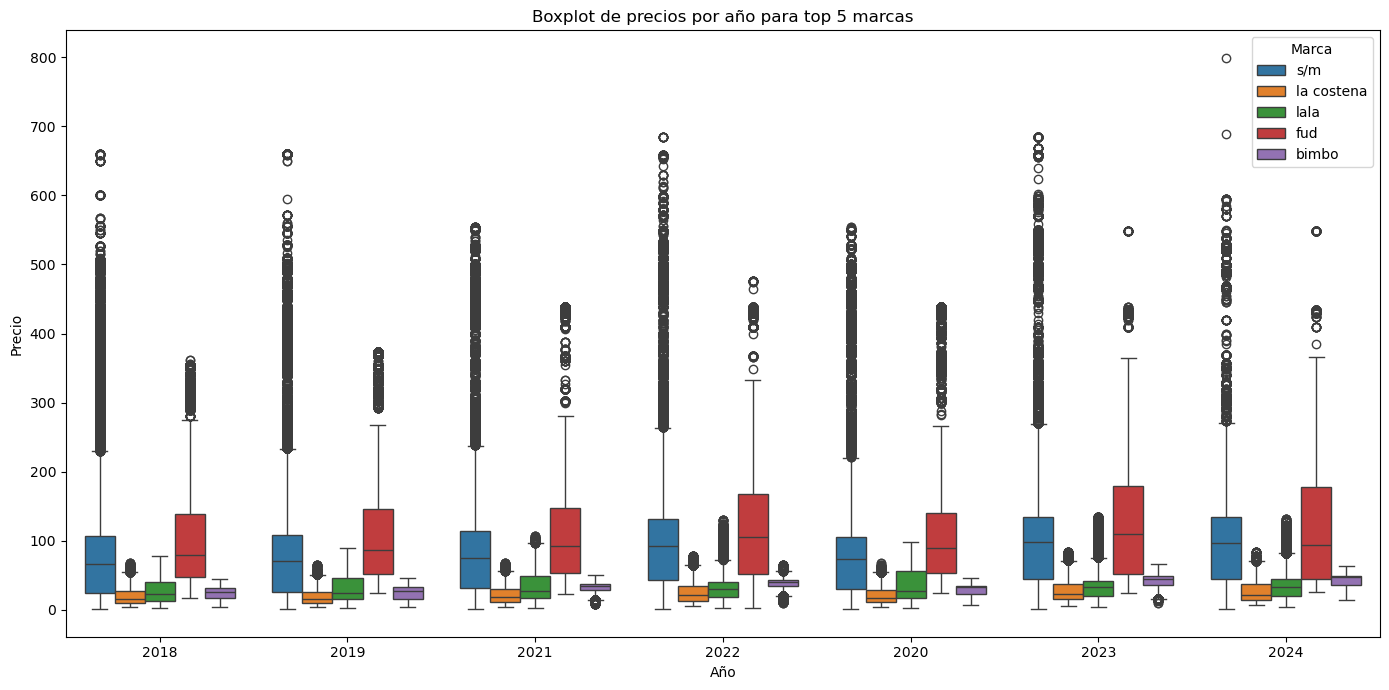

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
#Dibujamos el boxplot solicitado. 
plt.figure(figsize=(14, 7))
sns.boxplot(data=df_boxplot, x="anio", y="precio", hue="marca")
plt.title("Boxplot de precios por año para top 5 marcas")
plt.xlabel("Año")
plt.ylabel("Precio")
plt.legend(title="Marca")
plt.tight_layout()
plt.show()